In [1]:
library(dynlm)
library(car)
library(carData)
library(zoo)
library(xts)
library(tsbox)
library(tseries)
library(forecast)
library(astsa)
library(gvlma)
library(hwwntest)

Warning message:
"package 'dynlm' was built under R version 3.5.3"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.5.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'car' was built under R version 3.5.3"Loading required package: carData
Warning message:
"package 'carData' was built under R version 3.5.3"Warning message:
"package 'xts' was built under R version 3.5.3"Warning message:
"package 'tsbox' was built under R version 3.5.3"Warning message:
"package 'tseries' was built under R version 3.5.3"Warning message:
"package 'forecast' was built under R version 3.5.3"Warning message:
"package 'astsa' was built under R version 3.5.3"
Attaching package: 'astsa'

The following object is masked from 'package:forecast':

    gas

Warning message:
"package 'gvlma' was built under R version 3.5.2"Warning message:
"package 'hwwntest' was built under R version 3.5.3

In [2]:
# Making an xts object for the data
# Mumbai

mumbai <- as.data.frame(read.csv("../../Data/DistTimeSeries/Cases/Jaipur.csv", sep = ","))
mumbai$ï..Date <- as.Date(mumbai$ï..Date , format = "%d-%m-%Y")
colnames(mumbai) <- c("Date", "NewCases", "TotalCases", "Lockdown", "Temperature", "RH")
mumbai.xts <- xts(mumbai, order.by=mumbai$Date)
mumbai.xts <- mumbai.xts[, colnames(mumbai.xts) != "Date"]
head(mumbai)

Date,NewCases,TotalCases,Lockdown,Temperature,RH
2020-01-30,0,0,0,15,42
2020-01-31,0,0,0,16,44
2020-02-01,0,0,0,16,43
2020-02-02,0,0,0,16,41
2020-02-03,0,0,0,17,43
2020-02-04,0,0,0,15,45


In [16]:
# We make date with zero cases to 1 case
mumbai.xts$NewCases <- replace(mumbai.xts$NewCases, (as.numeric(mumbai.xts$NewCases) == 0), "1")

# Making new dataset after 20-Mar
startDate <- as.Date("25-Mar-20" , format = "%d-%b-%y")
endDate <- as.Date("27-Apr-20" , format = "%d-%b-%y")

newMumbai.xts <- subset(mumbai.xts, index(mumbai.xts)>=startDate)
newMumbai.xts <- subset(newMumbai.xts, index(newMumbai.xts)<=endDate)
# mumbai.xts$NewCases

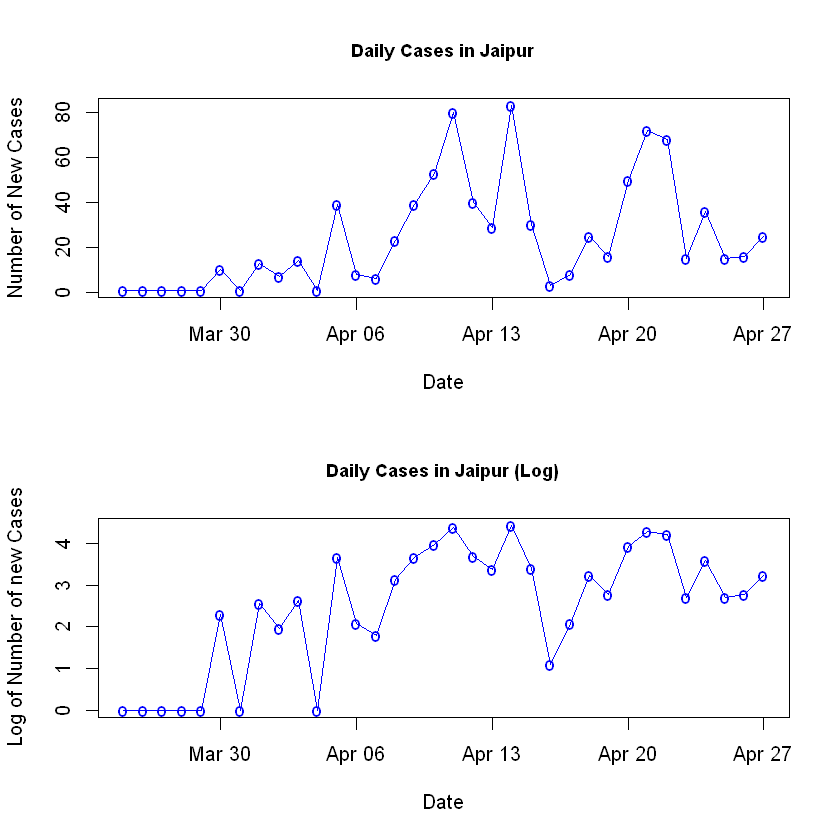

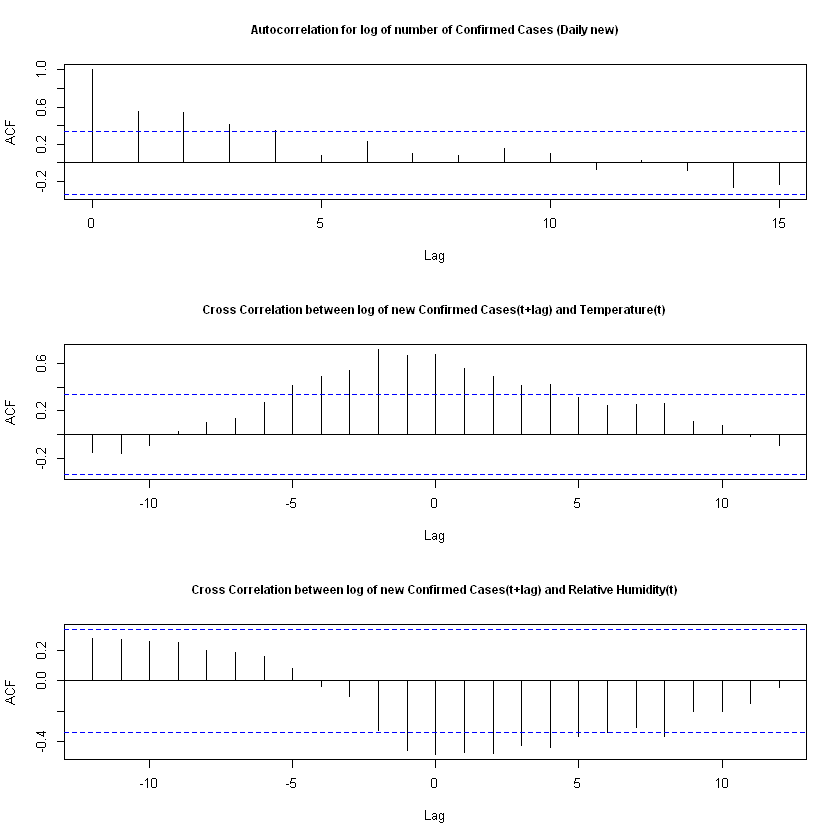

In [17]:
# Plots for Daily new Cases

par(mfrow = c(2,1), cex.main=0.9) # set up the graphics
plot(index(newMumbai.xts), newMumbai.xts$NewCases, type="o", col="blue", pch="o", lty=1, main="Daily Cases in Jaipur", ylab="Number of New Cases", xlab="Date")
plot(index(newMumbai.xts), log(as.numeric(newMumbai.xts$NewCases)), type="o", col="blue", pch="o", lty=1, main="Daily Cases in Jaipur (Log)", ylab="Log of Number of new Cases", xlab="Date")

par(mfrow = c(3,1), cex.main = 0.9)
acf(log(as.numeric(newMumbai.xts$NewCases)), main="Autocorrelation for log of number of Confirmed Cases (Daily new)")
ccf(log(as.numeric(newMumbai.xts$NewCases)), as.numeric(newMumbai.xts$Temperature), main="Cross Correlation between log of new Confirmed Cases(t+lag) and Temperature(t)")
ccf(log(as.numeric(newMumbai.xts$NewCases)), as.numeric(newMumbai.xts$RH), main="Cross Correlation between log of new Confirmed Cases(t+lag) and Relative Humidity(t)")


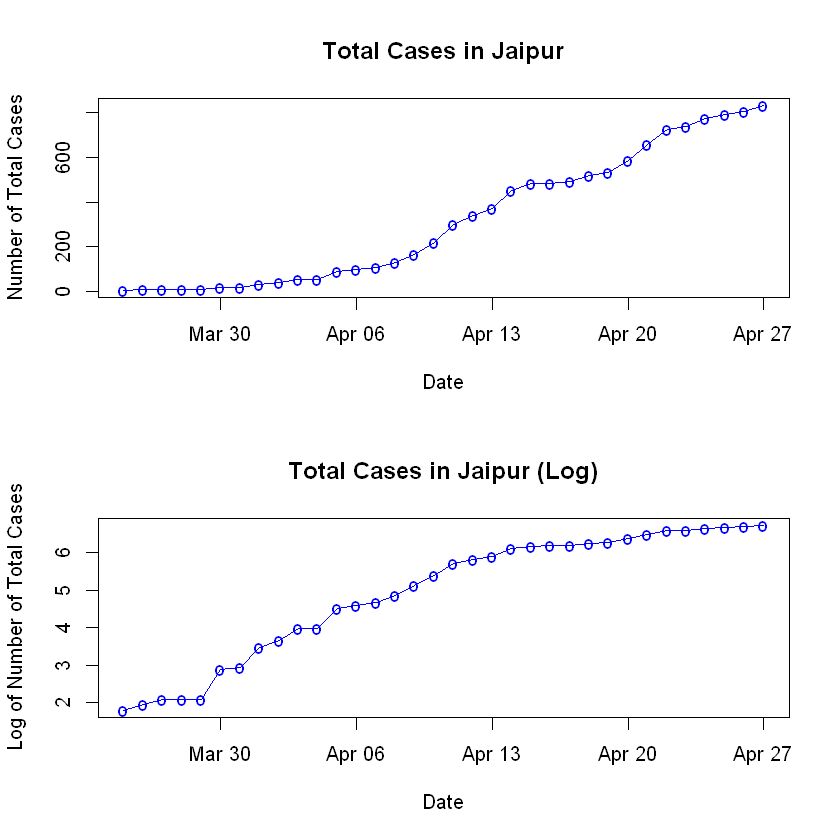

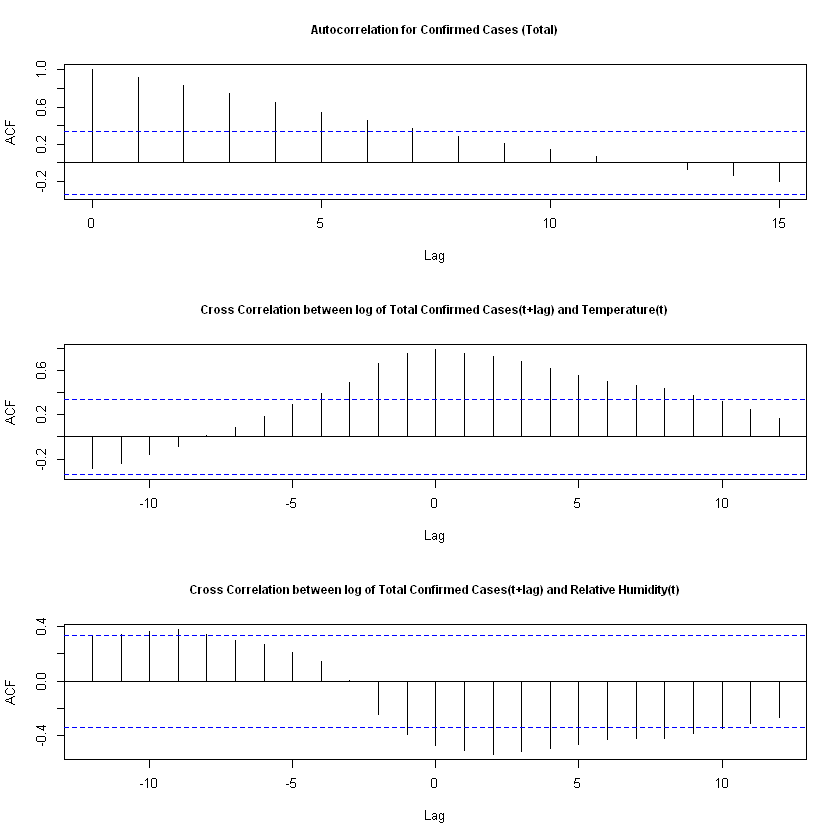

In [18]:
# Plots for Total Cases

par(mfrow = c(2,1)) # set up the graphics
plot(index(newMumbai.xts), newMumbai.xts$TotalCases, type="o", col="blue", pch="o", lty=1, main="Total Cases in Jaipur", ylab="Number of Total Cases", xlab="Date")
plot(index(newMumbai.xts), log(as.numeric(newMumbai.xts$TotalCases)), type="o", col="blue", pch="o", lty=1, main="Total Cases in Jaipur (Log)", ylab="Log of Number of Total Cases", xlab="Date")

par(mfrow = c(3,1), cex.main=0.9)
acf(log(as.numeric(newMumbai.xts$TotalCases)), main="Autocorrelation for Confirmed Cases (Total)")
ccf(log(as.numeric(newMumbai.xts$TotalCases)), as.numeric(newMumbai.xts$Temperature), cex=0.25, main="Cross Correlation between log of Total Confirmed Cases(t+lag) and Temperature(t)")
ccf(log(as.numeric(newMumbai.xts$TotalCases)), as.numeric(newMumbai.xts$RH), main="Cross Correlation between log of Total Confirmed Cases(t+lag) and Relative Humidity(t)")

In [19]:
# Making time squared trend to be fit
# Adding plus 1 kyunki baadme vo subtract ho jaayega
timeTrend_2 <- (1:length(index(newMumbai.xts))) ^2  
timeTrend <- (1:length(index(newMumbai.xts)))

mumbai.reg.data <- data.frame(log(as.numeric(coredata(newMumbai.xts$NewCases))),
                              as.numeric(coredata(newMumbai.xts$Temperature)), as.numeric(coredata(newMumbai.xts$RH)),   
                              timeTrend, timeTrend_2)
colnames(mumbai.reg.data) <- c("TimeSeries", "Temperature", "RH", "timeTrend", "timeTrend_2")

# mumbai.reg.data.matrix <- data.matrix(mumbai.reg.data)
# mumbai.reg.data.xts <- xts(mumbai.reg.data, order.by=index(newMumbai.xts))
mumbai.reg.data.ts <- as.ts(mumbai.reg.data, order.by=index(newMumbai.xts))
# index(mumbai.reg.data.zoo)
mumbai.reg.data.ts 

TimeSeries,Temperature,RH,timeTrend,timeTrend_2
0.000000,27,37,1,1
0.000000,25,48,2,4
0.000000,22,65,3,9
0.000000,25,42,4,16
0.000000,26,28,5,25
2.302585,26,26,6,36
0.000000,27,22,7,49
2.564949,28,25,8,64
1.945910,27,22,9,81
2.639057,28,15,10,100


## Let's de trend the total Cases Data



Time series regression with "ts" data:
Start = 2, End = 34

Call:
dynlm(formula = TimeSeries ~ timeTrend + timeTrend_2 + L(Temperature) + 
    L(RH, 1), data = mumbai.reg.data.ts)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3039 -0.4982  0.2459  0.5533  1.3038 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)   
(Intercept)     1.930298   3.690965   0.523  0.60510   
timeTrend       0.506057   0.154068   3.285  0.00275 **
timeTrend_2    -0.010660   0.003771  -2.827  0.00858 **
L(Temperature) -0.140930   0.129783  -1.086  0.28679   
L(RH, 1)        0.002859   0.029281   0.098  0.92290   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9721 on 28 degrees of freedom
Multiple R-squared:  0.6032,	Adjusted R-squared:  0.5465 
F-statistic: 10.64 on 4 and 28 DF,  p-value: 2.269e-05


[1] 98.36226

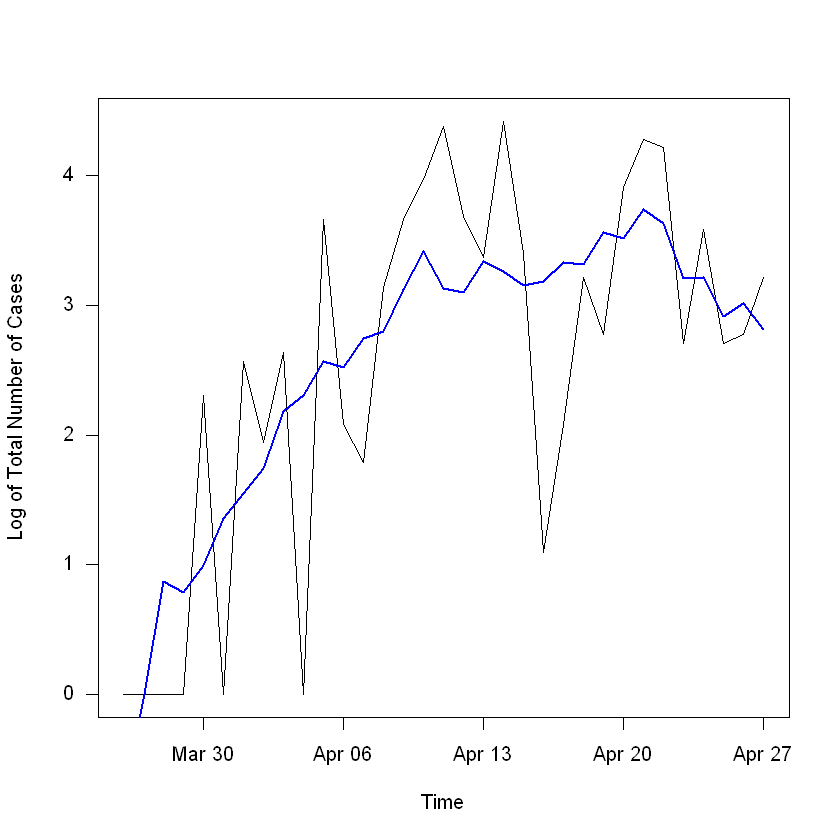

In [20]:
dataTimeSeries <- log(as.numeric(newMumbai.xts$NewCases))
numRows <- length(dataTimeSeries)
start = 2
detrended <- dynlm(TimeSeries ~ timeTrend+timeTrend_2+L(Temperature)+L(RH,1), data=mumbai.reg.data.ts)
summary(detrended)
prediction <- predict(detrended)
plot(index(newMumbai.xts)[start:numRows], dataTimeSeries[start:numRows], "l", las=1, xlab="Time", ylab="Log of Total Number of Cases")
lines(prediction~index(newMumbai.xts)[start:numRows], col="blue", lwd=2)
# plot(residuals(detrended))
# shapiro.test(detrended$residuals)
AIC(detrended)

In [21]:
# Forecasting
# Predicting for 26th, 27th and 28th
time <- c(35)
timeSquared <- time*time

# For 25th, 26th and 27th
temperature <- c(32)
RelHum <- c(30)
data <- data.frame(temperature, RelHum, time, timeSquared)
colnames(data) <- c("Temperature", "RH", "timeTrend", "timeTrend_2")
data
pred <- predict(detrended, newdata = data)
varianceError <- var(detrended$residuals)
varianceError <- varianceError/2
varianceError
exp(pred)
pred <- pred+varianceError
finalPred <- exp(pred)
finalPred
initial <- exp(dataTimeSeries[32])
initial

Temperature,RH,timeTrend,timeTrend_2
32,30,35,1225


[1] 0.4134518

1 
8.667688

1 
13.10579

[1] 15

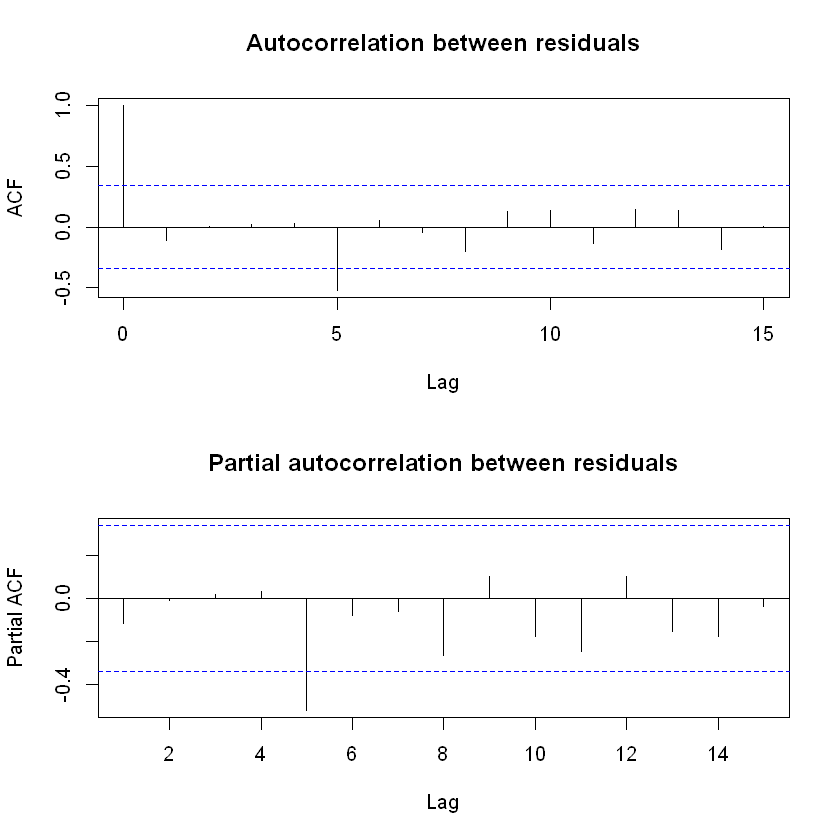

In [22]:
par(mfrow = c(2,1))
acf(detrended$residuals, main="Autocorrelation between residuals")
pacf(detrended$residuals, main="Partial autocorrelation between residuals")

In [37]:
nrows <- length(detrended$residuals)
residualTimeSeries <- detrended$residuals
fit <- auto.arima(residualTimeSeries, method="ML")
fit

Series: residualTimeSeries 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 0.008649:  log likelihood=22.95
AIC=-43.9   AICc=-43.72   BIC=-42.72